# Unpivot (Melt) Examples

This notebook demonstrates the `/unpivot` verb for converting wide-format data to long-format.

**Make sure to select the 'PYRSM DSL' kernel** (not Python).

In [1]:
/set-project ../..

Project directory set: `/home/vnijs/gh/pyrsm-mcp`

In [1]:
/set-data ../../data

Data directory set: `/home/vnijs/gh/pyrsm-mcp/data`

Found 30 data file(s):
- avengers.parquet
- carpet.parquet
- catalog.parquet
- city.parquet
- city2.parquet
- computer.parquet
- consider.parquet
- customers.csv
- customers_full.csv
- demand_uk.parquet
- ... and 20 more


## Create Sample Wide-Format Data

First, let's create some sample data in wide format - quarterly sales by region.

In [1]:
import polars as pl

# Create wide-format sales data
sales_wide = pl.DataFrame({
    "region": ["North", "South", "East", "West"],
    "Q1": [100, 200, 150, 175],
    "Q2": [120, 220, 160, 180],
    "Q3": [140, 240, 170, 190],
    "Q4": [160, 260, 180, 200],
})
print("Wide format:")
print(sales_wide)

Wide format:
shape: (4, 5)
┌────────┬─────┬─────┬─────┬─────┐
│ region ┆ Q1  ┆ Q2  ┆ Q3  ┆ Q4  │
│ ---    ┆ --- ┆ --- ┆ --- ┆ --- │
│ str    ┆ i64 ┆ i64 ┆ i64 ┆ i64 │
╞════════╪═════╪═════╪═════╪═════╡
│ North  ┆ 100 ┆ 120 ┆ 140 ┆ 160 │
│ South  ┆ 200 ┆ 220 ┆ 240 ┆ 260 │
│ East   ┆ 150 ┆ 160 ┆ 170 ┆ 180 │
│ West   ┆ 175 ┆ 180 ┆ 190 ┆ 200 │
└────────┴─────┴─────┴─────┴─────┘


## Basic Unpivot

Unpivot specific columns (Q1-Q4) while keeping `region` as an ID column.

In [1]:
sales_wide | /unpivot on=Q1 Q2 Q3 Q4 id_vars=region

region,variable,value
North,Q1,100
South,Q1,200
East,Q1,150
West,Q1,175
North,Q2,120
South,Q2,220
East,Q2,160
West,Q2,180
North,Q3,140
South,Q3,240


## Custom Column Names

Use `variable_name` and `value_name` to give meaningful names to the output columns.

In [1]:
sales_long = sales_wide | /unpivot on=Q1 Q2 Q3 Q4 id_vars=region variable_name=quarter value_name=sales
sales_long

region,quarter,sales
North,Q1,100
South,Q1,200
East,Q1,150
West,Q1,175
North,Q2,120
South,Q2,220
East,Q2,160
West,Q2,180
North,Q3,140
South,Q3,240


## Pivot and Unpivot Roundtrip

Pivot and unpivot are inverse operations. Let's demonstrate the roundtrip.

In [1]:
# Start with long format and pivot to wide
sales_long | /pivot rows=region cols=quarter values=sales agg=sum

region,Q4,Q2,Q1,Q3
North,160.0,120.0,100.0,140.0
West,200.0,180.0,175.0,190.0
South,260.0,220.0,200.0,240.0
East,180.0,160.0,150.0,170.0


## Real-World Example: Diamonds Dataset

Let's create a pivot table from the diamonds dataset and then unpivot it.

In [1]:
/load diamonds

Loaded 'diamonds': 3000 rows × 11 columns

In [1]:
# Create a pivot table: average price by cut and color
price_pivot = diamonds | /pivot rows=cut cols=color values=price agg=mean
price_pivot

cut,H,I,D,J,F,E,G
Ideal,3515.674556,4330.352381,2667.478528,4987.754717,3375.054622,2851.659794,3844.535433
Premium,5066.295455,5056.686747,3814.989130,7515.466667,4086.831933,3364.694444,3976.500000
Very Good,4207.294737,5409.881356,3299.974026,5212.410256,3669.727941,3566.442857,3864.274809
Good,3958.162162,6147.346154,3436.514286,3837.250000,3443.400000,3847.209677,5116.225000
Fair,5742.476190,2676.727273,4582.733333,6102.000000,5101.294118,3149.928571,3919.812500


In [1]:
# Unpivot back to long format for visualization or further analysis
price_pivot |
  /unpivot on=D E F G H I J id_vars=cut variable_name=color value_name=avg_price

cut,color,avg_price
Ideal,D,2667.478528
Premium,D,3814.989130
Very Good,D,3299.974026
Good,D,3436.514286
Fair,D,4582.733333
Ideal,E,2851.659794
Premium,E,3364.694444
Very Good,E,3566.442857
Good,E,3847.209677
Fair,E,3149.928571


## Unpivot Without Specifying `on`

If you don't specify `on`, all non-ID columns are unpivoted.

In [1]:
# All columns except region will be unpivoted
sales_wide | /unpivot id_vars=region

region,variable,value
North,Q1,100
South,Q1,200
East,Q1,150
West,Q1,175
North,Q2,120
South,Q2,220
East,Q2,160
West,Q2,180
North,Q3,140
South,Q3,240


## Unpivot Specific Columns Only

You can unpivot just a subset of columns.

In [1]:
# Only unpivot Q1 and Q2, leaving Q3 and Q4 as separate columns
sales_wide | /unpivot on=Q1 Q2 id_vars=region

region,variable,value
North,Q1,100
South,Q1,200
East,Q1,150
West,Q1,175
North,Q2,120
South,Q2,220
East,Q2,160
West,Q2,180


## Using Unpivot with Visualization

Long-format data is often better for visualization.

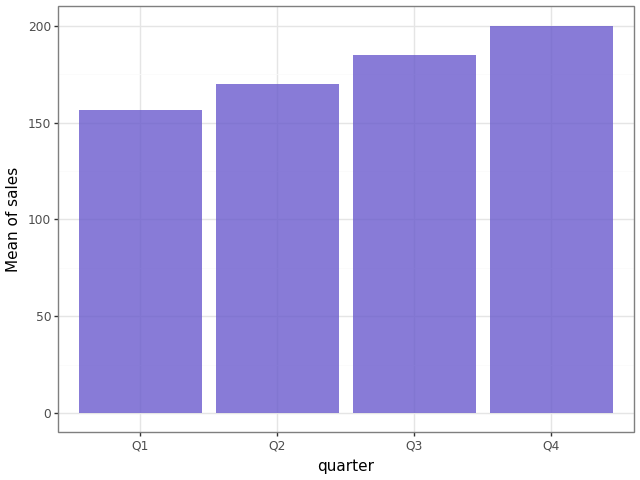

Code DSL: sales_wide | /unpivot on=Q1,Q2,Q3,Q4 id_vars=region variable_name=quarter value_name=sales | /visualize x=quarter y=sales geom=bar nobs=1000 agg=mean Python: data = rsm.eda.unpivot(sales_wide, on=['Q1', 'Q2', 'Q3', 'Q4'], id_vars='region', variable_name='quarter', value_name='sales')

model = rsm.eda.visualize(data, x='quarter', y='sales', geom='bar', nobs=1000, agg='mean')
model.summary(dec=3)

In [1]:
# Unpivot and visualize
sales_wide |
  /unpivot on=Q1 Q2 Q3 Q4 id_vars=region variable_name=quarter value_name=sales |
  /visualize x=quarter y=sales geom=bar agg=mean


## Parameter Reference

| Parameter | Description | Default |
|-----------|-------------|--------|
| `on` | Columns to unpivot (melt) | All non-ID columns |
| `id_vars` | Columns to keep as identifiers | None |
| `variable_name` | Name for the variable column | 'variable' |
| `value_name` | Name for the value column | 'value' |